In [124]:
import pandas as pd
import numpy as np

from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

In [125]:
df = pd.read_csv('marksheet.csv')
print(f"Before filtering:\n{len(df)} cases, {len(df[df['case_csPCa'] == 'YES'])} cancers")
df = df[['patient_id', 'study_id', 'mri_date', 'patient_age', 'psa', 'psad', 'prostate_volume', 'case_csPCa']]
df = df.dropna()
print(f"After filtering:\n{len(df)} cases, {len(df[df['case_csPCa'] == 'YES'])} cancers")
df['case_csPCa'] = df['case_csPCa'].apply(lambda v: v == 'YES')
df.head()

Before filtering:
1500 cases, 425 cancers
After filtering:
1040 cases, 298 cancers


,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,case_csPCa
1,10001,1000001,2016-05-27,64,8.7,0.09,102.0,False
2,10002,1000002,2021-04-18,58,4.2,0.06,74.0,False
4,10004,1000004,2020-10-21,67,8.0,0.10,78.0,False
5,10005,1000005,2012-07-18,64,12.1,0.24,51.0,True
6,10006,1000006,2020-10-23,73,6.2,0.23,27.0,False


In [126]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [127]:
pred_df = pd.DataFrame()

for train, val in kfold.split(df):
  train_df = df.iloc[train]
  val_df = df.iloc[val].copy()

  X_train = train_df[['patient_age', 'psa', 'psad', 'prostate_volume']]
  y_train = train_df['case_csPCa']
  X_val = val_df[['patient_age', 'psa', 'psad', 'prostate_volume']]
  y_val = val_df['case_csPCa']

  svc = SVC(probability=True, kernel='rbf', gamma=0.0001)
  svc.fit(X_train, y_train)

  val_df.loc[:, 'pred'] = svc.predict_proba(X_val)[:,1]

  pred_df = pd.concat([pred_df, val_df])

In [128]:
print(roc_auc_score(pred_df['case_csPCa'], pred_df['pred']))

0.7870597333526295


In [129]:
fpr, tpr, thresholds = roc_curve(pred_df['case_csPCa'], pred_df['pred'])

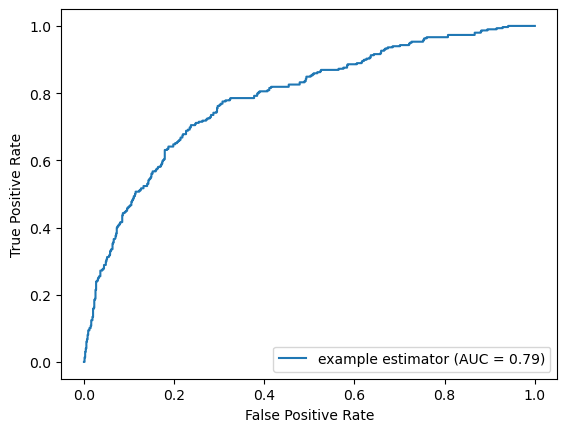

In [130]:
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_score(pred_df['case_csPCa'], pred_df['pred']), estimator_name='example estimator')
display.plot()